<a href="https://colab.research.google.com/github/sarbaniAi/healthcare-kipu/blob/master/KIPU_Topic_Modeling_FORMSDATA_with_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## UPGRAD - Topic Modeling Articles with NMF

We will be using NMF model to cluster Customer Complaints into different groups.Extracting topics is a good unsupervised data-mining technique to discover the underlying relationships between texts.

Other link - Text Classification in Spark NLP with Bert and Universal Sentence Encoders
Training a SOTA multi-class text classifier with Bert and Universal Sentence Encoders in Spark NLP with just a few lines of code in less than 10 min.

https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [73]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Colab Notebooks/dataset/Ticket analysis/complaints.json')
#complaints-2021-05-14_08_16.json') 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [74]:
df_form = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/kipu/kipu-data.csv")

In [75]:
df_form.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5963 entries, 0 to 5962
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   form_id                 5963 non-null   int64  
 1   form_name               5963 non-null   object 
 2   id                      5963 non-null   int64  
 3   evaluation_id           5963 non-null   int64  
 4   name                    5657 non-null   object 
 5   field_type              5804 non-null   object 
 6   column_names            131 non-null    object 
 7   record_names            2872 non-null   object 
 8   show_string             441 non-null    object 
 9   label                   5287 non-null   object 
 10  enabled                 5963 non-null   bool   
 11  created_at              5963 non-null   object 
 12  updated_at              5963 non-null   object 
 13  position                5953 non-null   float64
 14  css_style               4337 non-null   

In [76]:
df_form.shape

(5963, 34)

## Prepare the text for topic modeling

The dataset has 78313 customer complaints and 22 features. The customer complaint is in "_source.complaint_what_happened" column

We will rename the column names since they have changed due to normalization of JSON.

Remove rows with missing values in "complaint_what_happened" column

In [77]:
df_form

,form_id,form_name,id,evaluation_id,name,field_type,column_names,record_names,show_string,label,...,image_width,image_height,item_group,label_width,default_value,pre_populate_with_id,optional,parent_item_id,conditions,skip_validations
0,1005,Bio-psychosocial Assessment*,25262,1005,4. Does Client currently owe any restitution?,text,NaN,No,NaN,4. Does Client currently owe any restitution?,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,False
1,1005,Bio-psychosocial Assessment*,25287,1005,"If yes, was it alcohol/drug related?",radio_buttons,NaN,Yes|No|N/A,NaN,"If yes, was it alcohol/drug related?",...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
2,1005,Bio-psychosocial Assessment*,25288,1005,Have you ever been sexually abused?,radio_buttons,NaN,Yes|No,NaN,Have you ever been sexually abused?,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
3,1005,Bio-psychosocial Assessment*,25296,1005,Natural Disaster,radio_buttons,NaN,Yes|No,NaN,Natural Disaster,...,NaN,NaN,NaN,_40,NaN,NaN,False,NaN,NaN,False
4,1005,Bio-psychosocial Assessment*,25297,1005,Family Violence,radio_buttons,NaN,Yes|No,NaN,Family Violence,...,NaN,NaN,NaN,_40,NaN,NaN,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5958,1110,Nursing Care Plan: Cirrhosis and Liver Disease...,27379,1110,Treatment Plan Column Headings,treatment_plan_column_titles,NaN,<B>Assessment</B>|<B>Intervention</B>|<B>Frequ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
5959,1110,Nursing Care Plan: Cirrhosis and Liver Disease...,27380,1110,Objective 1,treatment_plan_item,NaN,Nurse and/or physician will assess patient’s u...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
5960,1110,Nursing Care Plan: Cirrhosis and Liver Disease...,27381,1110,Objective 2,treatment_plan_item,NaN,Nurse will assess patient’s knowledge of compl...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
5961,1110,Nursing Care Plan: Cirrhosis and Liver Disease...,27382,1110,Objective 3,treatment_plan_item,NaN,Nurses will assess for signs and symptoms of e...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False


In [78]:
#print the column names
list(df_form.columns)

['form_id',
 'form_name',
 'id',
 'evaluation_id',
 'name',
 'field_type',
 'column_names',
 'record_names',
 'show_string',
 'label',
 'enabled',
 'created_at',
 'updated_at',
 'position',
 'css_style',
 'matrix_default_records',
 'show_string_css',
 'divider_below',
 'rule',
 'placeholder',
 'image_file_name',
 'image_content_type',
 'image_file_size',
 'image_updated_at',
 'image_width',
 'image_height',
 'item_group',
 'label_width',
 'default_value',
 'pre_populate_with_id',
 'optional',
 'parent_item_id',
 'conditions',
 'skip_validations']

In [79]:
df=df_form[['form_name','name','field_type']]


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5963 entries, 0 to 5962
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   form_name   5963 non-null   object
 1   name        5657 non-null   object
 2   field_type  5804 non-null   object
dtypes: object(3)
memory usage: 139.9+ KB


In [81]:
#Assigning new column names
#df.columns = ["index","type","id","score","tags","zip_code","complaint_id","issue","date_received","state","consumer_disputed","product","company_response","company","submitted_via","date_sent_to_company","company_public_response","sub_product","timely","complaint_what_happened","sub_issue","consumer_consent_provided"]

In [82]:
#Assigning nan in place of blanks in the complaints column(complaint_what_happened)
df[df['name']==''] = np.nan
df[df['field_type']==''] = np.nan

In [83]:
#Removing all rows where complaints column is nan
df=df.dropna(subset=['name'])

In [84]:
df=df.dropna(subset=['field_type'])

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5569 entries, 0 to 5962
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   form_name   5569 non-null   object
 1   name        5569 non-null   object
 2   field_type  5569 non-null   object
dtypes: object(3)
memory usage: 174.0+ KB


## Prepare the text for topic modeling

There are 21072 rows after removing all the blank complaints.

Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers

Use POS tags to get relevant words from the texts. Using Nouns just 

Lemmatize the texts

In [86]:
df

,form_name,name,field_type
0,Bio-psychosocial Assessment*,4. Does Client currently owe any restitution?,text
1,Bio-psychosocial Assessment*,"If yes, was it alcohol/drug related?",radio_buttons
2,Bio-psychosocial Assessment*,Have you ever been sexually abused?,radio_buttons
3,Bio-psychosocial Assessment*,Natural Disaster,radio_buttons
4,Bio-psychosocial Assessment*,Family Violence,radio_buttons
...,...,...,...
5958,Nursing Care Plan: Cirrhosis and Liver Disease...,Treatment Plan Column Headings,treatment_plan_column_titles
5959,Nursing Care Plan: Cirrhosis and Liver Disease...,Objective 1,treatment_plan_item
5960,Nursing Care Plan: Cirrhosis and Liver Disease...,Objective 2,treatment_plan_item
5961,Nursing Care Plan: Cirrhosis and Liver Disease...,Objective 3,treatment_plan_item


In [87]:
df['name'].value_counts()

(c) Kipu September 2020                                                                                                                                                                                                               84
Date                                                                                                                                                                                                                                  40
Additional Notes                                                                                                                                                                                                                      23
Treatment Plan Column Headings                                                                                                                                                                                                        22
Objective 1                                                         

In [88]:
df['form_name'].value_counts()

ED - Yale-Brown Obsessive Compulsive Scale  (Y-BOCS)    239
History and Physical - Conditional Logic                212
Bio-psychosocial Assessment*                            194
ED Assessment                                           163
Bio-psychosocial Assessment                             154
                                                       ... 
Confidentiality Policy                                    1
Activities Release and Waiver of Liability                1
Veersa Billing Form                                       1
Tx Hx                                                     1
Kittiy Billing Form                                       1
Name: form_name, Length: 198, dtype: int64

In [89]:
df['field_type'].value_counts()

title                                 1013
text                                  1009
radio_buttons                          755
check_box                              647
string                                 419
                                      ... 
patient.anticipated_discharge_date       1
patient.level_of_care_ur                 1
rounds_assignment                        1
patient.drug_of_choice                   1
patient.medication_verification          1
Name: field_type, Length: 71, dtype: int64

In [90]:
import re, nltk, spacy, string
pd.options.mode.chained_assignment = None  
df.name=df.name.astype(str)
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_clean = pd.DataFrame(df.name.apply(lambda x: clean_text(x)))

In [91]:
#Function to Lemmatize the texts
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [92]:
#Creating a dataframe that will have only the complaints and the lemmatized complaints.
import en_core_web_sm
nlp = en_core_web_sm.load()
df_clean["name_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['name']), axis=1)

In [93]:
df_clean

,name,name_lemmatize
0,does client currently owe any restitution,do client currently owe any restitution
1,if yes was it alcoholdrug related,if yes be -PRON- alcoholdrug relate
2,have you ever been sexually abused,have -PRON- ever be sexually abuse
3,natural disaster,natural disaster
4,family violence,family violence
...,...,...
5958,treatment plan column headings,treatment plan column heading
5959,objective,objective
5960,objective,objective
5961,objective,objective


In [94]:
'''One thing to notice is unlike verbs and common nouns, there's no clear base form of a personal pronoun. 
Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? 
spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.'''

'One thing to notice is unlike verbs and common nouns, there\'s no clear base form of a personal pronoun. \nShould the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? \nspaCy\'s solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.'

In [95]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [96]:
#Using custom Chunking
#Chunking in NLP is a process to take small pieces of information and group them into large units. The primary use of Chunking is making groups of "noun phrases.
#Here we are using only noun, singular as we have already lemmatized the texts.
import pandas as pd
from textblob import TextBlob

def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_adjectives(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

df_clean["name_POS_removed"] =  df_clean.apply(lambda x: get_adjectives(x['name_lemmatize']), axis=1)

In [97]:
#Now the clean dataframe .
df_clean

,name,name_lemmatize,name_POS_removed
0,does client currently owe any restitution,do client currently owe any restitution,client restitution
1,if yes was it alcoholdrug related,if yes be -PRON- alcoholdrug relate,relate
2,have you ever been sexually abused,have -PRON- ever be sexually abuse,
3,natural disaster,natural disaster,disaster
4,family violence,family violence,family violence
...,...,...,...
5958,treatment plan column headings,treatment plan column heading,treatment plan
5959,objective,objective,objective
5960,objective,objective,objective
5961,objective,objective,objective


## Let’s do some quick exploratory data analysis to get familiar with the data.

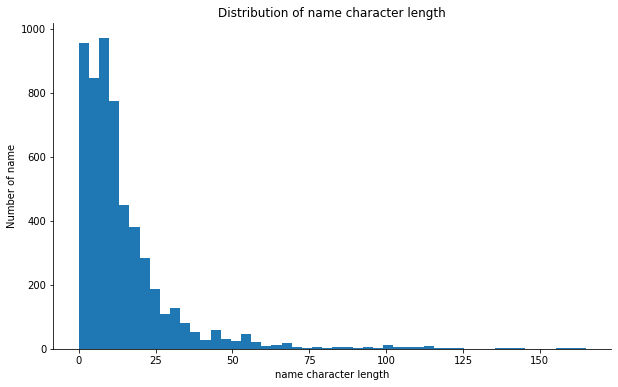

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.name_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.title('Distribution of name character length')
plt.ylabel('Number of name')
plt.xlabel('name character length')
sns.despine();

## In terms of the distribution of the word counts, it’s skewed a little positive but overall it’s a pretty normal distribution

## Here are the top 40 words by frequency among all the articles after processing the text.

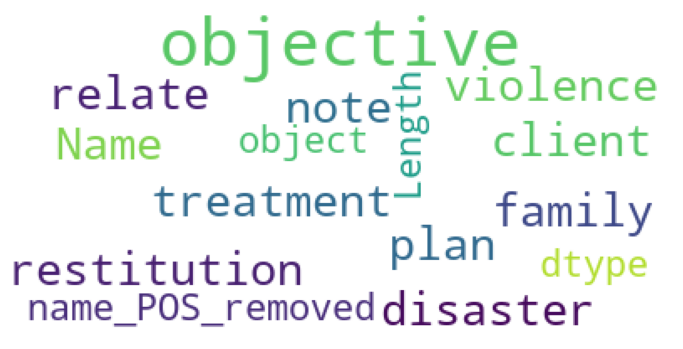

In [99]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['name_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [100]:
#Removing -PRON- from the text corpus
df_clean['name_clean'] = df_clean['name_POS_removed'].str.replace('-PRON-', '')

## Here are the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

'Credit’, ‘debt’, ‘bank’, ‘loan’ and ‘mortgage’ are some of the top words which makes sense given the focus of the complaints.

In [101]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['name_clean'].values.astype('U'), 50)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [102]:
df2.head(10)

,unigram,count
0,client,319
1,treatment,249
2,dimension,214
3,history,213
4,date,199
5,weight,124
6,eat,117
7,level,107
8,time,102
9,problem,101


In [103]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['name_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [104]:
df3.head(5)

,bigram,count
0,eat disorder,58
1,treatment plan,55
2,situation dimension,54
3,client situation,52
4,level care,50


In [105]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['name_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the Complaint text"))
fig.show()

In [106]:
df4.head(10)

,trigram,count
0,client situation dimension,49
1,situation dimension followingi,25
2,intoxication andor withdrawal,20
3,andor withdrawal potential,20
4,dimension condition complication,20
5,dimension behavioral condition,20
6,behavioral condition complication,20
7,dimension acute intoxication,19
8,acute intoxication andor,19
9,dimension recovery environment,19


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [107]:
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [108]:
#All masked texts has been removed
#df_clean

## Lets now convert the raw texts to a matrix of TF-IDF features

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

min_df is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [109]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

## Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [110]:
dtm = tfidf.fit_transform(df_clean['name_clean'])

## NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In [111]:
from sklearn.decomposition import NMF

## Coherence Model to select best number of Topics
With the Coherence Model we will see how to automatically select the best number of topics. 


In [112]:
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary

In [113]:
!python -m pip install -U gensim


In [114]:
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [115]:


# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['name_clean']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


## Manual Topic Modeling
With the CoherenceModel we got the best number of topics=5.The hard work is already done at this point so all we need to do is run the model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [116]:
nmf_model = NMF(n_components=5,random_state=40)

In [117]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

890

In [118]:
#Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

admit
today
service
onset
attempt
admission
discharge
time
evaluation
date


In [119]:
#Print Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['seizure', 'transfer', 'fall', 'medication', 'assessment', 'admit', 'today', 'service', 'onset', 'attempt', 'admission', 'discharge', 'time', 'evaluation', 'date']


THE TOP 15 WORDS FOR TOPIC #1
['goal', 'problem', 'environment', 'level', 'recovery', 'follow', 'complication', 'plan', 'status', 'condition', 'followingi', 'treatment', 'situation', 'dimension', 'client']


THE TOP 15 WORDS FOR TOPIC #2
['change', 'dental', 'checklist', 'height', 'drug', 'day', 'disorder', 'present', 'age', 'time', 'list', 'eat', 'weight', 'problem', 'september']


THE TOP 15 WORDS FOR TOPIC #3
['exercise', 'seizure', 'use', 'abuse', 'plan', 'follow', 'drug', 'substance', 'behavior', 'disorder', 'eat', 'weight', 'family', 'treatment', 'history']


THE TOP 15 WORDS FOR TOPIC #4
['change', 'dental', 'height', 'checklist', 'drug', 'day', 'disorder', 'present', 'age', 'time', 'list', 'eat', 'weight', 'problem', 'objective']




In [120]:
#Creating the best topic for each complaint
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([1, 3, 0, ..., 4, 4, 3])

In [121]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [122]:
df_clean.head()

,name,name_lemmatize,name_POS_removed,name_clean,Topic
0,does client currently owe any restitution,do client currently owe any restitution,client restitution,client restitution,1
1,if yes was it alcoholdrug related,if yes be -PRON- alcoholdrug relate,relate,relate,3
2,have you ever been sexually abused,have -PRON- ever be sexually abuse,,,0
3,natural disaster,natural disaster,disaster,disaster,0
4,family violence,family violence,family violence,family violence,3


In [123]:
#Print the first 5 question for each of the Topics
df_dc=df_clean.groupby('Topic').head(5)
df_dc.sort_values('Topic')

,name,name_lemmatize,name_POS_removed,name_clean,Topic
17,why or why not,why or why not,,,0
44,covid positive,covid positive,covid,covid,0
2,have you ever been sexually abused,have -PRON- ever be sexually abuse,,,0
3,natural disaster,natural disaster,disaster,disaster,0
38,date,date,date,date,0
12,is client externally motivated for treatment,be client externally motivate for treatment,client treatment,client treatment,1
11,xii treatment acceptance resistance dimension,xii treatment acceptance resistance dimension,treatment acceptance resistance dimension,treatment acceptance resistance dimension,1
0,does client currently owe any restitution,do client currently owe any restitution,client restitution,client restitution,1
5,time abstinent from each prior treatment,time abstinent from each prior treatment,time abstinent treatment,time abstinent treatment,1
7,what precipitating events lead to relapse ie t...,what precipitate event lead to relapse ie trigger,event lead trigger,event lead trigger,1


In [124]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Topic1",1:"Topic2", 2:"Others",3:"Topic3",4:"Topic4"}

In [125]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [126]:
df_clean

,name,name_lemmatize,name_POS_removed,name_clean,Topic
0,does client currently owe any restitution,do client currently owe any restitution,client restitution,client restitution,Topic2
1,if yes was it alcoholdrug related,if yes be -PRON- alcoholdrug relate,relate,relate,Topic3
2,have you ever been sexually abused,have -PRON- ever be sexually abuse,,,Topic1
3,natural disaster,natural disaster,disaster,disaster,Topic1
4,family violence,family violence,family violence,family violence,Topic3
...,...,...,...,...,...
5958,treatment plan column headings,treatment plan column heading,treatment plan,treatment plan,Topic2
5959,objective,objective,objective,objective,Topic4
5960,objective,objective,objective,objective,Topic4
5961,objective,objective,objective,objective,Topic4


## Supervised model to predict any new complaints to the relevant Topics.

We have seen how to get the topics of the complaints, now in the below section we will see how we can use them to classify any new complaints.

Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [127]:
Topic_names = {"Topic1":0,"Topic2":1,"Others":2,"Topic3":3,"Topic4":4}
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [128]:
df_clean

,name,name_lemmatize,name_POS_removed,name_clean,Topic
0,does client currently owe any restitution,do client currently owe any restitution,client restitution,client restitution,1
1,if yes was it alcoholdrug related,if yes be -PRON- alcoholdrug relate,relate,relate,3
2,have you ever been sexually abused,have -PRON- ever be sexually abuse,,,0
3,natural disaster,natural disaster,disaster,disaster,0
4,family violence,family violence,family violence,family violence,3
...,...,...,...,...,...
5958,treatment plan column headings,treatment plan column heading,treatment plan,treatment plan,1
5959,objective,objective,objective,objective,4
5960,objective,objective,objective,objective,4
5961,objective,objective,objective,objective,4


In [129]:
training_data=df_clean[["name","Topic"]]

In [130]:
training_data

,name,Topic
0,does client currently owe any restitution,1
1,if yes was it alcoholdrug related,3
2,have you ever been sexually abused,0
3,natural disaster,0
4,family violence,3
...,...,...
5958,treatment plan column headings,1
5959,objective,4
5960,objective,4
5961,objective,4


In [139]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer


#GET VECTOR COUNT
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.name)

#SAVE WORD VECTOR
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [140]:
from sklearn.feature_extraction.text import TfidfTransformer

#TRANSFORM WORD VECTOR TO TF IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [141]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = MultinomialNB().fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("nb_model.pkl", "wb"))

In [146]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4", "Topic5"]

docs_new = "Have you ever been sexually abused?"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("nb_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic1


In [147]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

#for predicted_item, result in zip(predicted, y_test):
 #   print(target_names[predicted_item], ' - ', target_names[result])

In [149]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[254 165   0  20   0]
 [ 10 545   0  11   0]
 [  0   0  26   0   0]
 [ 17  47   0 271   0]
 [  2   0   0   0  25]]
              precision    recall  f1-score   support

      Topic1       0.90      0.58      0.70       439
      Topic2       0.72      0.96      0.82       566
      Topic3       1.00      1.00      1.00        26
      Topic4       0.90      0.81      0.85       335
      Topic5       1.00      0.93      0.96        27

    accuracy                           0.80      1393
   macro avg       0.90      0.86      0.87      1393
weighted avg       0.83      0.80      0.80      1393



In [153]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("logreg_model.pkl", "wb"))

In [154]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "Has any family member / significant other attempted to address / intervene in Clientâ€™s behavior and / or usage?"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("logreg_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [155]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Topic4  -  Topic4
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic1  -  Topic1
Topic1  -  Topic1
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic1  -  Topic1
Topic1  -  Topic1
Topic4  -  Topic4
Topic4  -  Topic4
Topic2  -  Topic2
Topic4  -  Topic4
Topic1  -  Topic1
Topic1  -  Topic1
Topic1  -  Topic2
Topic1  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic1  -  Topic1
Topic1  -  Topic4
Topic4  -  Topic4
Topic1  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic4
Topic5  -  Topic5
Topic1  -  Topic1
Topic2  -  Topic2
Topic1  -  Topic1
Topic4  -  Topic4
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic4  -  Topic4
Topic1  -  Topic1
Topic4  -  Topic4
Topic1  -  Topic2
Topic1  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic1  -  Topic1
Topic1  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic4
Topic1  -  Topic1
Topic1  - 

In [156]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[403  17   0  16   3]
 [ 36 518   0  12   0]
 [  0   0  26   0   0]
 [ 43  28   0 264   0]
 [  0   0   0   0  27]]
                             precision    recall  f1-score   support

      Bank Account services       0.84      0.92      0.88       439
Credit card or prepaid card       0.92      0.92      0.92       566
              Mortgage/Loan       1.00      1.00      1.00        26
            Theft Reporting       0.90      0.79      0.84       335
                     Others       0.90      1.00      0.95        27

                   accuracy                           0.89      1393
                  macro avg       0.91      0.92      0.92      1393
               weighted avg       0.89      0.89      0.89      1393



In [157]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("DT_model.pkl", "wb"))

In [159]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "CLINICAL SUMMARY OF CLIENTâ€™S RESPONSE TO TREATMENT<br />(strengths/weaknesses, specific needs and concerns upon discharge)"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("DT_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [160]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Topic4  -  Topic4
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic1  -  Topic1
Topic1  -  Topic1
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic1
Topic4  -  Topic4
Topic4  -  Topic4
Topic2  -  Topic2
Topic4  -  Topic4
Topic1  -  Topic1
Topic1  -  Topic1
Topic1  -  Topic2
Topic1  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic1  -  Topic1
Topic4  -  Topic4
Topic4  -  Topic4
Topic1  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic4
Topic5  -  Topic5
Topic1  -  Topic1
Topic2  -  Topic2
Topic1  -  Topic1
Topic4  -  Topic4
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic4  -  Topic4
Topic1  -  Topic1
Topic4  -  Topic4
Topic4  -  Topic2
Topic1  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic1  -  Topic1
Topic1  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic4
Topic1  -  Topic1
Topic1  - 

In [161]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[406  22   0  11   0]
 [ 53 492   0  21   0]
 [  0   0  26   0   0]
 [ 37  32   0 266   0]
 [  0   0   0   0  27]]
              precision    recall  f1-score   support

      Topic1       0.82      0.92      0.87       439
      Topic2       0.90      0.87      0.88       566
      Topic3       1.00      1.00      1.00        26
      Topic4       0.89      0.79      0.84       335
      Topic5       1.00      1.00      1.00        27

    accuracy                           0.87      1393
   macro avg       0.92      0.92      0.92      1393
weighted avg       0.88      0.87      0.87      1393



In [162]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("RF_model.pkl", "wb"))

In [164]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "If YES, is Client satisfied with relationship with partner?"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("RF_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [165]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Topic2  -  Topic4
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic1
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic1
Topic4  -  Topic4
Topic4  -  Topic4
Topic2  -  Topic2
Topic4  -  Topic4
Topic1  -  Topic1
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic2  -  Topic1
Topic2  -  Topic4
Topic2  -  Topic4
Topic2  -  Topic1
Topic2  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic4
Topic2  -  Topic5
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic4
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic4
Topic2  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic1
Topic4  -  Topic4
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic4
Topic2  -  Topic1
Topic2  - 

In [166]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[ 70 369   0   0   0]
 [  0 566   0   0   0]
 [  0   0  26   0   0]
 [  0 258   0  77   0]
 [  0  27   0   0   0]]
              precision    recall  f1-score   support

      Topic1       1.00      0.16      0.28       439
      Topic2       0.46      1.00      0.63       566
      Topic3       1.00      1.00      1.00        26
      Topic4       1.00      0.23      0.37       335
      Topic5       0.00      0.00      0.00        27

    accuracy                           0.53      1393
   macro avg       0.69      0.48      0.46      1393
weighted avg       0.76      0.53      0.45      1393

